# Assignment 1. Logistic Regression 관련 구현
1) 로지스틱 회귀 모형의 Objective Function을 구현.  
2) Gradient Descent 알고리즘을 구현하고, 1)을 이에 적용.  
    → 주석 제대로 달 것. 주석 없이 Copy 시 미제출로 간주함.  
    → Stochastic 버전도 같이 구현 시 우수과제 선정 가능성이 높아집니다!  
    (혹은 다른 Optimization Method를 찾아서 구현해보셔도 좋아요.)  


* 제가 제시한 틀을 사용하여 구현을 할 필요는 없습니다. 원하시는 대로 구현하시면 됩니다.  
* 단, code copy는 허용하지 않습니다. 코드 주석을 꼭 상세히 달아주세요. 주석이 부족한 경우, 미제출로 간주합니다.
   
   
---

In [1]:
import math, random
from functools import partial,reduce
from assignment2 import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
"""
data 설명
1) Label: 유료 계정 등록 여부(target)
2) bias: 회귀 모형에서의 상수항을 위한 term (추정 시 포함하지 않아도 ok)
3) experience: 근속연수
4) salary: 연봉

어떤 사용자가 유료 계정을 등록할지(Label == 1)에 대한 예측을 로지스틱 회귀 모형으로 진행합니다.
"""

'\ndata 설명\n1) Label: 유료 계정 등록 여부(target)\n2) bias: 회귀 모형에서의 상수항을 위한 term (추정 시 포함하지 않아도 ok)\n3) experience: 근속연수\n4) salary: 연봉\n\n어떤 사용자가 유료 계정을 등록할지(Label == 1)에 대한 예측을 로지스틱 회귀 모형으로 진행합니다.\n'

In [3]:
data = pd.read_csv('assignment_2.csv')

In [4]:
data

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000
5,0,1,6.5,69000
6,0,1,7.5,76000
7,0,1,8.1,88000
8,1,1,8.7,83000
9,1,1,10.0,83000


### 0. Gradient Descent

In [5]:
def step(v, direction, step_size):
    """
    한 지점에서 step size만큼 이동하는 step 함수를 구현하세요.
    v와 direction은 벡터.
    """
    # v : 모델에서 현재 parameter vector
    # direction : objective function을 parameter vector에 대해 편미분한 gradient vector
    # new_parameter = old_parameter - learning_rate * gradient 방식으로 parameter update
    return [i-step_size*j for i, j in zip(v, direction)]

In [6]:
def safe(f) :
    """
    f에 대한 예외처리를 위한 함수(f가 infinite일 때)
    """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

In [7]:
def minimize_bgd(target_fn, gradient_fn, theta_0, tolerance = 0.00001): # bgd: batch gradient descent
    """
    목적함수를 최소화시키는 theta를 경사 하강법을 사용해서 찾는다.
    """
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001] # 여러가지 step sizes에 대해서 테스트
    
    theta = theta_0 # 시작점 설정
    target_fn = safe(target_fn) # 함수가 infinite일 때의 오류를 처리할 수 있는 target_fn으로 변환
    value = target_fn(theta) # 현재 model 에서의 target function value
    
    while True:
        gradient = gradient_fn(theta) # 현재 theta에서의 gradient (목적함수를 theta에서 미분한 값)
        next_thetas =  [step(theta, gradient, step_size) for step_size in step_sizes] # 다양한 learning_rate에 대해서 다음 thetas를 구함


        obj = next_thetas 
        key = target_fn # 최소화하는 함수 = 목적함수
        next_theta = min(obj, key = key) # 위에서 구한 next_thetas 중 목적함수를 가장 최소화하는 theta 하나만 구함
        next_value = target_fn(next_theta) # new_theta에서의 목적함수 값
        
        # print(f'value={value}, next_value={next_value} ')
        # tolerance만큼 수렴하면 멈춤
        temp = abs(value-next_value) # old_theta에서의 목적함수의 값과 new_theta에서의 목적함수의 값의 차이
        if temp < tolerance: # tolerance보다 작으면 stop
            return theta
        else: # tolerance보다 크면 다시 theta와 value를 update
            theta = next_theta
            value = next_value
        

In [8]:
def stochastic():
    """
    sgd 구현 (추가적인 부분이니 필수는 아닙니다.)
    random sampling 하는 부분(함수로 따로 구현하셔도 ok) + gd 부분
    
    """

### 1. 로지스틱 함수
해당 함수는 1/(1+exp[-(ax+b)]로 표현되었음을 기억합시다.

In [9]:
def logistic(x):
    try:
        return 1.0 / (1 + math.exp(-x)) # 시그모이드 함수 
    except:
        return 1e-8 

In [10]:
def softmax():
    """
    softmax 구현
    """
    return None

### 2. Likelihood 구현
그냥 Likelihood function 대신, log likelihood function을 이용해서 구현하세요.

In [11]:
def logistic_log_likelihood_i(x_i, y_i, beta): # 개별 데이터포인트에 대한 likelihood 값
    """
    해당 함수에 대한 설명을 작성하고,
    리턴문을 채우세요.
    """
    if y_i == 1:
        # target이 1일 때
        return math.log(logistic(dot(x_i, beta))) 
    else:
        # target이 0일 때
        return math.log(1-logistic(dot(x_i, beta))) 

In [12]:
def logistic_log_likelihood(X, y, beta): # 전체 데이터에 대한 likelihood
    """
    함수의 인자를 채워넣고,
    zip 함수를 이용하여 return 문을 완성하세요.
    """
    
    # 각 데이터에서 구한 log_likelihood의 합
    log_likelihood =  [logistic_log_likelihood_i(x_i, y_i, beta) for x_i, y_i in zip(X, y)]
    return sum( log_likelihood ) 

### 3. Gradient for Log Reg
아래 3가지 함수에 대해 해당 함수의 인자와 기능을 자세히 설명하세요.

In [13]:
# def vector_add(v, w):
#     return [v_i + w_i for v_i, w_i in zip(v,w)]

In [14]:
# x_i : 하나의 데이터 (한 개의 row)
# y_i : target value
# beta : parameter
# j번째 beta에 대해서 편미분 하라는 의미
# -> 즉, log likelihood 값을 j번째 beta에 대해서 편미분한 값
def logistic_log_partial_ij(x_i, y_i, beta, j):
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

# 하나의 데이터에 대해서 log likelihood 값을 계산한 후
# 모든 beta에 대해서 편미분해서 나온 gradient vector를 return
def logistic_log_gradient_i(x_i, y_i, beta):
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j, _ in enumerate(beta)]


# 모든 데이터에 대해서 log likelihood 값을 계산한 후
# 모든 beta에 대해서 편미분해서 나온 gradient vector를 return
# [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x, y)]
# => 리스트 속 리스트(하나의 데이터에 대해서 나온 gradient)
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add, [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x, y)])

In [15]:
reduce(vector_add, [[1, 2, 3], [4, 5, 6]])

[5, 7, 9]

###설명###

### 4. Model Fitting
위에서 구현한 log likelihood를 이용하여 Model을 Fitting 시켜보세요.  
앞서 우리는 log likelihood를 maximize하는 방향으로 회귀계수를 추정한다고 배웠습니다.  
Gradient Descent는 경사 "하강법"으로 최솟값을 찾는 데에 사용되는 알고리즘입니다.  
따라서 log likelihood를 적절히 변형을 해야 Gradient Descent 코드를 적용할 수 있습니다.  
log likelihood 변형 함수는 assignment2.py에 구현되어있으니, None값만 채워주시면 됩니다.

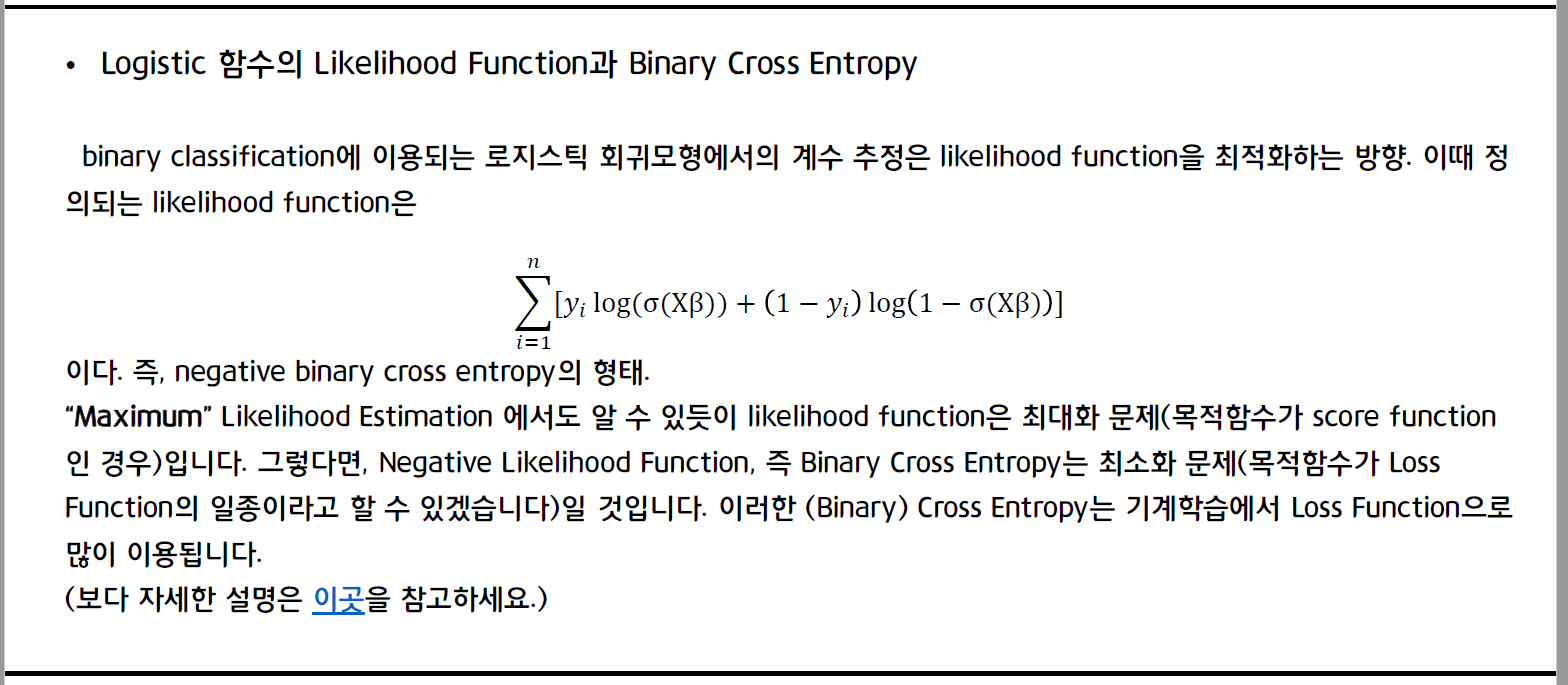  
https://curt-park.github.io/2018-09-19/loss-cross-entropy/

In [16]:
data

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000
5,0,1,6.5,69000
6,0,1,7.5,76000
7,0,1,8.1,88000
8,1,1,8.7,83000
9,1,1,10.0,83000


In [17]:
X = data.drop('Label', axis = 1) # feature
y = data['Label'].values # target

0    0.74
1    0.26
dtype: float64


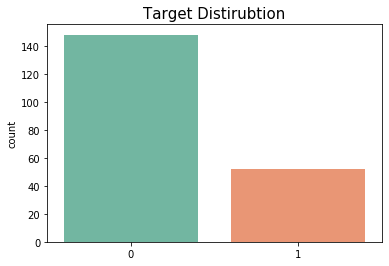

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y, palette='Set2')
plt.title('Target Distirubtion', fontsize=15)

print(pd.Series(y).value_counts()/len(y))

# 0인 target 0.74% (148건)
# 1인 target 0.26% (52건)

In [18]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler() # standard scaling
X = standard_scaler.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split
import random

In [20]:
random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [21]:
# 아래에 Model Fitting 진행
from functools import partial # partial을 이용해 fn과 gradient_fn 구현

# 위에서 짠 코드는 목적함수를 최소화하는 방향으로 학습을 진행하는데,
# log likelihood를 목적함수로 사용할 경우 최대회되는 방향으로 학습이 이뤄져야 한다.
# 따라서 neg를 이용해 negative log likelihood를 목적함수로 지정
fn = neg(partial(logistic_log_likelihood, X_train, y_train))
gradient_fn = neg_all(partial(logistic_log_gradient, X_train, y_train))

beta_0 = [random.random() for _ in range(3)] # 임의의 시작점


# 경사 하강법으로 최적화
beta_hat = minimize_bgd(fn, gradient_fn, beta_0)

In [22]:
beta_hat

[0.8444218515250481, 2.6123852042859523, -2.538819721385238]

## sklearn과 비교
우리가 구현한 함수와 sklearn의 LogisticRegression을 비교해보도록 하겠다.

In [23]:
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [24]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
sk_predict_value = lr_clf.predict(X_test)
sk_predict_proba = lr_clf.predict_proba(X_test)[:, 1]

In [63]:
# 여러가지 평가지표 값을 반환해주는 함수 작성
def get_score(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    print('accuracy\t> {}'.format( round(accuracy, 4)))
    print('recall\t\t> {}'.format( round(recall, 4)))
    print('precision\t> {}'.format( round(precision, 4)))
    print('auc\t\t> {}'.format( round(auc, 4)))
    
    return (accuracy, recall, precision, auc)
    

In [44]:
# threshold를 변화해가며 어떤 threshold에서 평가지표가 좋은 지 확인해보고자 한다.
def change_threshold(X, beta, threshold):
    values = X.dot(beta)
    predict_proba = [logistic(value) for value in values]
    predict_value = [1 if proba>=threshold else 0 for proba in predict_proba]
    return predict_value, predict_proba

### 구현한 함수에서 threshold 조정

In [45]:
# 구현한 gradient descent의 성능
import numpy as np
thresholds = np.arange(0.2, 0.9, 0.1)
for threshold in thresholds:
    predict_value, predict_proba = change_threshold(X_test, beta_hat, threshold)
    print(f'threshold = {threshold}')
    get_score(y_test, predict_value, predict_proba)
    print('='*50)
    
# threshold는 0.2부터 0.8까지 0.1 간격으로 변화해보았다.
# 여기서는 accuracy를 주된 평가지표로 사용하도록 하겠다. 
# (유료계정을 등록할 지, 하지 않을지 둘 다 예측해야 하는 문제라고 생각했기 때문에)
# threshold를 0.7, 0.8로 설정했을 때 accuracy가 0.90으로 가장 높았으며
# 다른 평가지표들도 threshold가 0.7, 0.8일 때 전반적으로 고르게 높게 나왔다.
# 우리는 0.7~0.8 근처의 값에서 좀 더 세밀하게 threshold를 조절해보려고 한다.

threshold = 0.2
accuracy	> 0.5152
recall		> 1.0
precision	> 0.3191
auc		> 0.9634
threshold = 0.30000000000000004
accuracy	> 0.6061
recall		> 1.0
precision	> 0.3659
auc		> 0.9634
threshold = 0.4000000000000001
accuracy	> 0.697
recall		> 1.0
precision	> 0.4286
auc		> 0.9634
threshold = 0.5000000000000001
accuracy	> 0.803
recall		> 1.0
precision	> 0.5357
auc		> 0.9634
threshold = 0.6000000000000001
accuracy	> 0.8333
recall		> 0.9333
precision	> 0.5833
auc		> 0.9634
threshold = 0.7000000000000002
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9634
threshold = 0.8000000000000003
accuracy	> 0.9091
recall		> 0.8
precision	> 0.8
auc		> 0.9634


In [93]:
accuracy_dict.values()

dict_values([0.9090909090909091, 0.9090909090909091, 0.9242424242424242, 0.9242424242424242, 0.9393939393939394, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9242424242424242, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.8939393939393939, 0.8939393939393939, 0.9090909090909091, 0.8787878787878788, 0.8636363636363636, 0.8181818181818182, 0.8181818181818182, 0.8333333333333334, 0.8333333333333334])

threshold = 0.7
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9634
threshold = 0.71
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9634
threshold = 0.72
accuracy	> 0.9242
recall		> 0.9333
precision	> 0.7778
auc		> 0.9634
threshold = 0.73
accuracy	> 0.9242
recall		> 0.9333
precision	> 0.7778
auc		> 0.9634
threshold = 0.74
accuracy	> 0.9394
recall		> 0.9333
precision	> 0.8235
auc		> 0.9634
threshold = 0.75
accuracy	> 0.9242
recall		> 0.8667
precision	> 0.8125
auc		> 0.9634
threshold = 0.76
accuracy	> 0.9242
recall		> 0.8667
precision	> 0.8125
auc		> 0.9634
threshold = 0.77
accuracy	> 0.9242
recall		> 0.8667
precision	> 0.8125
auc		> 0.9634
threshold = 0.78
accuracy	> 0.9242
recall		> 0.8667
precision	> 0.8125
auc		> 0.9634
threshold = 0.79
accuracy	> 0.9091
recall		> 0.8
precision	> 0.8
auc		> 0.9634
threshold = 0.8
accuracy	> 0.9091
recall		> 0.8
precision	> 0.8
auc		> 0.9634
threshold = 0.81
accuracy	> 0.9091
recall		> 0.7333
precision	> 0.8462
auc		> 0

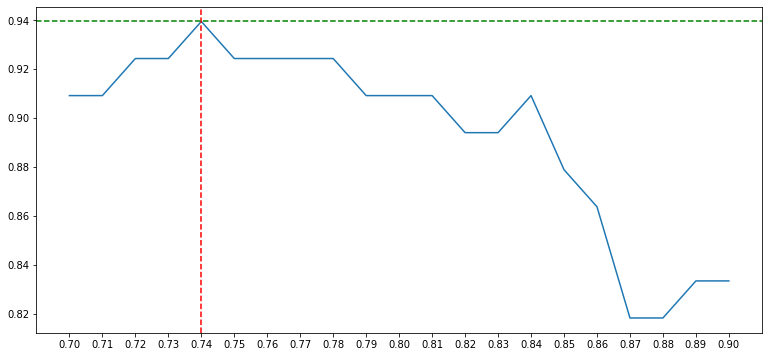

In [96]:
thresholds = np.arange(0.7, 0.9, 0.01)
accuracy_dict = {}
for threshold in thresholds:
    predict_value, predict_proba = change_threshold(X_test, beta_hat, threshold)
    print(f'threshold = {threshold}')
    accuracy, _, _, _ = get_score(y_test, predict_value, predict_proba)
    accuracy_dict[threshold] = accuracy
    print('='*50)

plt.figure(figsize=(13, 6))
sns.lineplot(x=thresholds, y=list(accuracy_dict.values()))
plt.axvline(x=0.74, ymin=0, ymax=1, ls='--', c='red')
plt.axhline(y=accuracy_dict[0.74], xmin=0, xmax=1, ls='--', c='green')
plt.xticks(ticks=thresholds)
plt.show()

# 구간을 좀 더 세밀하게 하여 thresholds를 조정해본 결과
# threhsold가 0.74일 때 accuracy가 0.9394로 가장 높게 나왔다.
# 이 때의 다른 평가지표들도 다른 threshold에 비해 고르게 좋은 결과가 나왔다.

### sklearn의 LogisticRegression에서 threshold 조정

In [74]:
# sklearn의 LogisticRegression의 성능
get_score(y_test, sk_predict_value, sk_predict_proba)

accuracy	> 0.8939
recall		> 0.6667
precision	> 0.8333
auc		> 0.9595


(0.8939393939393939,
 0.6666666666666666,
 0.8333333333333334,
 0.9594771241830066)

In [76]:
thresholds = np.arange(0.2, 0.9, 0.1)
for threshold in thresholds:
    predict_value = [1 if proba>=threshold else 0 for proba in sk_predict_proba]
    print(f'threshold = {threshold}')
    get_score(y_test, predict_value, sk_predict_proba)
    print('='*50)
    
# 위에서와 동일하게 threshold는 0.2부터 0.8까지 0.1 간격으로 변화해보았다.
# sklearn의 Logistic에서는 우리가 구현한 함수와는 다르게 threshold가 0.4일 때 accuracy가 0.9242로 가장 높았다.
# (우리가 구현한 함수에서는 threshold를 0.7, 0.8로 설정했을 때 accuracy가 0.90으로 가장 높았다)
# 이번에는 0.4 근처의 값에서 threshold를 좀 더 세밀하게 조정해보도록 하겠다.

threshold = 0.2
accuracy	> 0.803
recall		> 1.0
precision	> 0.5357
auc		> 0.9595
threshold = 0.30000000000000004
accuracy	> 0.8788
recall		> 0.9333
precision	> 0.6667
auc		> 0.9595
threshold = 0.4000000000000001
accuracy	> 0.9242
recall		> 0.8667
precision	> 0.8125
auc		> 0.9595
threshold = 0.5000000000000001
accuracy	> 0.8939
recall		> 0.6667
precision	> 0.8333
auc		> 0.9595
threshold = 0.6000000000000001
accuracy	> 0.8182
recall		> 0.2667
precision	> 0.8
auc		> 0.9595
threshold = 0.7000000000000002
accuracy	> 0.8182
recall		> 0.2
precision	> 1.0
auc		> 0.9595
threshold = 0.8000000000000003
accuracy	> 0.8182
recall		> 0.2
precision	> 1.0
auc		> 0.9595


threshold = 0.3
accuracy	> 0.8788
recall		> 0.9333
precision	> 0.6667
auc		> 0.9595
threshold = 0.31
accuracy	> 0.8939
recall		> 0.9333
precision	> 0.7
auc		> 0.9595
threshold = 0.32
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9595
threshold = 0.33
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9595
threshold = 0.34
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9595
threshold = 0.35000000000000003
accuracy	> 0.9091
recall		> 0.9333
precision	> 0.7368
auc		> 0.9595
threshold = 0.36000000000000004
accuracy	> 0.9242
recall		> 0.9333
precision	> 0.7778
auc		> 0.9595
threshold = 0.37000000000000005
accuracy	> 0.9242
recall		> 0.9333
precision	> 0.7778
auc		> 0.9595
threshold = 0.38000000000000006
accuracy	> 0.9242
recall		> 0.9333
precision	> 0.7778
auc		> 0.9595
threshold = 0.39000000000000007
accuracy	> 0.9394
recall		> 0.9333
precision	> 0.8235
auc		> 0.9595
threshold = 0.4000000000000001
accuracy	> 0.9242
recall		> 0.8667
precision	> 0

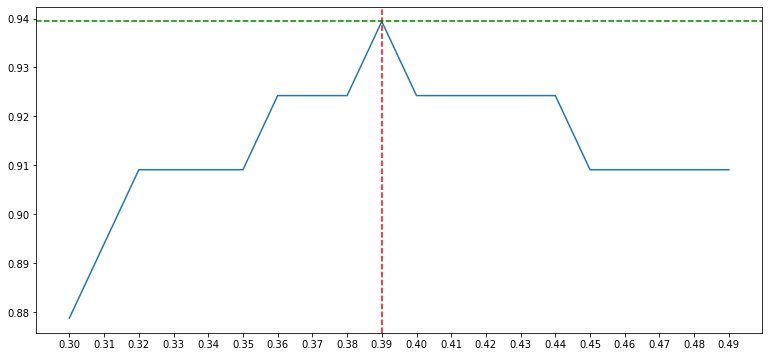

In [107]:
thresholds = np.arange(0.3, 0.5, 0.01)
accuracy_dict = {}
for threshold in thresholds:
    predict_value = [1 if proba>=threshold else 0 for proba in sk_predict_proba]
    print(f'threshold = {threshold}')
    accuracy, _, _, _ = get_score(y_test, predict_value, sk_predict_proba)
    accuracy_dict[round(threshold, 3)] = accuracy
    print('='*50)

plt.figure(figsize=(13, 6))
sns.lineplot(x=thresholds, y=list(accuracy_dict.values()))
plt.axvline(x=0.39, ymin=0, ymax=1, ls='--', c='red')
plt.axhline(y=accuracy_dict[0.39], xmin=0, xmax=1, ls='--', c='green')
plt.xticks(ticks=thresholds)
plt.show()

# 구간을 좀 더 세밀하게 하여 thresholds를 조정해본 결과
# threhsold가 0.39일 때 accuracy가 0.9394로 가장 높게 나왔다.
# 이 때의 다른 평가지표들도 다른 threshold에 비해 고르게 좋은 결과가 나왔다.

In [ ]:
# threshold를 조정했을 때 나온 best 결과는 아래와 같다.

# 구현함 함수
# threshold = 0.74
# accuracy > 0.9394
# recall > 0.9333
# precision > 0.8235
# auc > 0.9634

# sklearn LogisticRegression
# threshold = 0.39
# accuracy > 0.9394
# recall > 0.9333
# precision > 0.8235
# auc > 0.9595

# accuracy를 기준으로 best 결과를 뽑아본 결과 threshold에는 차이가 있었으나
# 전반적인 평가지표에는 큰 차이가 없었다. (accuracy, recall, precision이 소수점 넷째자리에서 동일하다! 신기하다)